# Dataset creation

This notebook will create a dataset labeling.... bla bla

In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import csv
import re

## 1. Index of ratings creation

First we need the ratings for each top level domain name to be quickly accessible

### 1.1 Loading the newsguard data

In [2]:
newsguard_df = pd.read_csv("newsguard_ratings.csv")

In [3]:
newsguard_df

,identifier,identifierAlt,rank,healthGuard,country,groupName,siteOnline,parent,score,topline
0,nanotechnology.news,naturalnews.com,N,True,US,naturalnews.com website network,True,naturalnews.com,5.0,A &nbsp;site that is part of a network of hund...
1,yorkshirepost.co.uk,NaN,T,True,GB,NaN,True,NaN,95.0,"The website of the Yorkshire Post, a daily new..."
2,davvero.tv,NaN,TK,False,ALL,NaN,True,NaN,0.0,NaN
3,cdc.gov,cdc.gov,T,True,US,NaN,True,cdc.gov,100.0,The website for the U.S. Centers for Disease C...
4,greenmedinfo.com,greenmedinfo.com,N,True,US,NaN,True,greenmedinfo.com,30.0,A website that has promoted unproven cures for...
...,...,...,...,...,...,...,...,...,...,...
1689,washingtonpost.com,NaN,T,True,US,NaN,True,NaN,100.0,"The website for The Washington Post, a leading..."
1690,ilpiacenza.it,milanotoday.it,T,True,ALL,citynews websites network,True,milanotoday.it,82.5,A network&nbsp;of approximately 50 local newsp...
1691,optimagazine.com,NaN,N,True,ALL,NaN,True,NaN,12.5,A digital magazine about music and pop culture...
1692,reitschuster.de,NaN,N,False,ALL,NaN,True,NaN,59.5,A news blog run by journalist Boris Reitschust...


### 1.2 Building the ratings index

In [4]:
# Concatenate on 0 axis
newsguard_index = pd.concat([
    newsguard_df[["identifier", "score"]].dropna(),
    newsguard_df[["identifierAlt", "score"]].rename({"identifierAlt": "identifier"}, axis=1).dropna()])

newsguard_index.drop_duplicates(inplace=True)
newsguard_index.sort_values(by="identifier", inplace=True)
newsguard_index.set_index("identifier", inplace=True)

In [5]:
newsguard_index

,score
identifier,
100giornidaleoni.it,30.0
10news.com,100.0
11alive.com,100.0
13wham.com,90.0
14news.com,100.0
...,...
zdf.de,100.0
zdnet.com,100.0
zeit.de,92.5


## 2. Labeling

In [6]:
# Root lookup
def get_newsguard_ratings(urlist, index_df):
    
    ratings = []
    
    for url in urlist:
        
        try:
            ratings.append(index_df.loc[url.lower()].values[0])
        except KeyError:
            continue
            
    return ratings

# Example test
get_newsguard_ratings(["zeit.de", "davvero.tv", "pluto.com"], newsguard_index)

[92.5, 0.0]

In [7]:
# Show columns and index
cols = pd.read_csv("tweets_processed.csv", nrows=0).columns
[print(n, col) for n, col in enumerate(cols)];

0 Unnamed: 0
1 id
2 created_at
3 user_id
4 user_screen_name
5 geo
6 place
7 lang
8 truncated
9 text
10 retweet_count
11 likes_count
12 retweeted_text
13 user_mentions
14 hashtags
15 urls
16 is_quote
17 is_reply
18 is_original
19 is_retweet
20 in_reply_to_status_id
21 in_reply_to_screen_name
22 quoted_text
23 retweeted_status_id
24 retweeted_user_screen_name
25 quoted_urls
26 quoted_hashtags
27 quoted_created_at
28 quoted_status_id
29 quoted_user_screen_name
30 media
31 positive
32 neutral
33 negative


In [38]:

url_pattern = r"(?:(?:https?://(?:www\.)?)|(?:www\.))(\w+\.\w+)(?:/?)"
url_regex = re.compile(url_pattern)

stats = {"tweets_processed": 0,
         "tweets_corrupted": 0,
         "tweets_accepted": 0,   # A tweet is accepted if has any URLs in text OR in quoted text and URLs are known.
         "tweets_accepted_originals": 0,          # Original tweets with URL(s)
         "tweets_accepted_retweets": 0,           # Retweets with URL(s)
         "tweets_accepted_replies": 0,            # Replies with URL(s)
         "tweets_accepted_quotations": 0,         # Quotes with URL(s) of tweets with URL(s) or not 
         "tweets_accepted_quotations_strict": 0,  # Quotes with URL(s) of tweets with URL(s)
         "tweets_with_urls": 0,
         "tweets_original_with_urls": 0,
         "tweets_retweets_with_urls": 0,
         "tweets_replies_with_urls": 0,
         "tweets_quotations_with_urls": 0,
         "tweets_quotations_with_urls_strict": 0}

tweets_limit = None #10000 # Set this to limit the number of CSV rows to process or None to process all

# Open two file streams at the same time: source and destination.
with open("tweets_processed.csv", 'r') as csv_src, open("tweets_newsguard.csv", 'w') as csv_dst:
    
    csv_reader = csv.reader(csv_src, delimiter=',')
    csv_writer = csv.writer(csv_dst, delimiter=',')
    
    for n, row in tqdm(enumerate(csv_reader)):
        
        if n == 0:
            # Header settings
            csv_writer.writerow(row[1:] + ["roots", "quoted_roots", "ng_ratings", "ng_ratings_quoted"])
    
        elif not tweets_limit or n <= tweets_limit:
            
            stats["tweets_processed"] += 1
            
            # Unpack
            try:
                urls = row[15]
                quoted_urls = row[25]
                is_original = int(row[18])
                is_retweet = int(row[19])
                is_reply = int(row[17])
                is_quote = int(row[16])
            except IndexError:
                stats["tweets_corrupted"] += 1
                continue
            
            # Get URLs
            roots = url_regex.findall(urls)
            quoted_roots = url_regex.findall(quoted_urls)
            
            stats["tweets_with_urls"] += 1 if roots or quoted_roots else 0
            stats["tweets_original_with_urls"] += 1 if is_original == 1 and roots else 0
            stats["tweets_retweets_with_urls"] += 1 if is_retweet == 1 and roots else 0
            stats["tweets_replies_with_urls"] += 1 if is_reply == 1 and roots else 0
            stats["tweets_quotations_with_urls"] += 1 if is_quote == 1 and roots else 0
            stats["tweets_quotations_with_urls_strict"] += 1 if is_quote == 1 and roots and quoted_roots else 0
            
            # Get ratings from known urls
            ratings = get_newsguard_ratings(roots, newsguard_index)
            quoted_ratings = get_newsguard_ratings(quoted_roots, newsguard_index)
                
            
            if ratings or quoted_ratings:
                
                stats["tweets_accepted"] += 1
                
                # Format add information to current row
                ng_info = [str(roots), str(quoted_roots), str(ratings), str(quoted_ratings)]
                csv_writer.writerow(row[1:] + ng_info)
                
                stats["tweets_accepted_originals"] += 1 if is_original == 1 and ratings else 0
                stats["tweets_accepted_retweets"] += 1 if is_retweet == 1 and ratings else 0
                stats["tweets_accepted_replies"] += 1 if is_reply == 1 and ratings else 0
                stats["tweets_accepted_quotations"] += 1 if is_quote == 1 and ratings else 0
                stats["tweets_accepted_quotations_strict"] += 1 if is_quote == 1 and ratings and quoted_ratings else 0

        else:
                  
            break

12687225it [01:41, 124620.82it/s]


In [39]:
stats

{'tweets_processed': 12687224,
 'tweets_corrupted': 195,
 'tweets_accepted': 1220046,
 'tweets_accepted_originals': 441028,
 'tweets_accepted_retweets': 361789,
 'tweets_accepted_replies': 72541,
 'tweets_accepted_quotations': 7912,
 'tweets_accepted_quotations_strict': 1998,
 'tweets_with_urls': 2679983,
 'tweets_original_with_urls': 1020744,
 'tweets_retweets_with_urls': 628063,
 'tweets_replies_with_urls': 143611,
 'tweets_quotations_with_urls': 243144,
 'tweets_quotations_with_urls_strict': 96935}

In [19]:
import pandas as pd

df = pd.read_csv("tweets_newsguard.csv", low_memory=False)

In [20]:
df["created_at"] = pd.to_datetime(df["created_at"])

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1220046 entries, 0 to 1220045
Data columns (total 37 columns):
 #   Column                      Non-Null Count    Dtype              
---  ------                      --------------    -----              
 0   id                          1220046 non-null  int64              
 1   created_at                  1220046 non-null  datetime64[ns, UTC]
 2   user_id                     1220046 non-null  int64              
 3   user_screen_name            1220046 non-null  object             
 4   geo                         83 non-null       object             
 5   place                       8201 non-null     object             
 6   lang                        1220046 non-null  object             
 7   truncated                   1188667 non-null  float64            
 8   text                        858257 non-null   object             
 9   retweet_count               1220046 non-null  int64              
 10  likes_count                 12

In [22]:
df.sort_values(by="created_at", inplace=True)

In [23]:
dataset_df = df[((df["is_original"] == 1) | (df["is_retweet"] == 1)) & (df["ng_ratings"] != '[]')]

In [24]:
dataset_df = dataset_df.copy()

In [25]:
dataset_df["date"] = (dataset_df["created_at"].dt.day.astype(str) + "." +
                      dataset_df["created_at"].dt.month.astype(str) + "." +
                      dataset_df["created_at"].dt.year.astype(str))

In [26]:
dataset_df

,id,created_at,user_id,user_screen_name,geo,place,lang,truncated,text,retweet_count,...,quoted_user_screen_name,media,positive,neutral,negative,roots,quoted_roots,ng_ratings,ng_ratings_quoted,date
2,1340468299025551360,2020-12-20 01:25:21+00:00,497188910,Rosskitty77,NaN,NaN,und,NaN,NaN,4,...,NaN,NaN,NaN,NaN,NaN,['affaritaliani.it'],[],[64.5],[],20.12.2020
3,1340468728534884354,2020-12-20 01:27:04+00:00,924336025387913221,real_fabristol,NaN,NaN,it,NaN,"Covid, l’offensiva cinese: al via i vaccini ne...",0,...,NaN,NaN,0.000439,0.998082,0.001479,['lastampa.it'],[],[95.0],[],20.12.2020
5,1340473042129080320,2020-12-20 01:44:12+00:00,47148805,mcocucci,NaN,NaN,it,NaN,Non sono morte però sono state ricoverate in t...,0,...,NaN,NaN,0.002690,0.975340,0.021970,['nytimes.com'],[],[100.0],[],20.12.2020
6,1340474125656190978,2020-12-20 01:48:31+00:00,1022891525242593280,LisciandroC,NaN,NaN,it,NaN,Politici avvertiti: chi impone vaccini obbliga...,1,...,NaN,NaN,NaN,NaN,NaN,['imolaoggi.it'],[],[5.0],[],20.12.2020
7,1340477947627581440,2020-12-20 02:03:42+00:00,908206586,deegibons,NaN,NaN,it,NaN,Un virus più contagioso alla base della second...,0,...,NaN,NaN,NaN,NaN,NaN,"['repubblica.it', 'tweetedtimes.com']",[],[95.0],[],20.12.2020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
198800,1451536158098399236,2021-10-22 13:09:22+00:00,1260895357548068865,negromanten1,NaN,NaN,it,0.0,"I vaccinati per forza non la prenderanno bene,...",0,...,NaN,NaN,NaN,NaN,NaN,['maurizioblondet.it'],[],[20.0],[],22.10.2021
198801,1451536212381011970,2021-10-22 13:09:35+00:00,1329549977463508993,MariaFi27832951,NaN,NaN,it,0.0,NaN,0,...,NaN,NaN,NaN,NaN,NaN,['stopcensura.online'],[],[39.5],[],22.10.2021
198802,1451536226876526601,2021-10-22 13:09:39+00:00,712365073,Alcesten,NaN,NaN,it,0.0,NaN,0,...,NaN,NaN,NaN,NaN,NaN,['lapekoranera.it'],[],[12.5],[],22.10.2021
198803,1451536327388942348,2021-10-22 13:10:03+00:00,1036611673,GiancarloChimie,NaN,NaN,it,0.0,NaN,0,...,NaN,NaN,NaN,NaN,NaN,['maurizioblondet.it'],[],[20.0],[],22.10.2021


In [27]:
dataset_df["count"] = 1

In [28]:
tweets_per_day_df = dataset_df[["date", "count"]].groupby("date").agg("sum")

In [29]:
tweets_per_day_df = tweets_per_day_df.reset_index()

In [30]:
tweets_per_day_df

,date,count
0,1.1.2021,2011
1,1.10.2021,2174
2,1.2.2021,1805
3,1.3.2021,2358
4,1.4.2021,3570
...,...,...
302,9.5.2021,1435
303,9.6.2021,3498
304,9.7.2021,1616
305,9.8.2021,1639


In [31]:
tweets_per_day_df["date"] = pd.to_datetime(tweets_per_day_df["date"], format="%d.%m.%Y")

In [32]:
tweets_per_day_df = tweets_per_day_df.sort_values(by="date").reset_index(drop=True)

In [33]:
tweets_per_day_df

,date,count
0,2020-12-20,1317
1,2020-12-21,1679
2,2020-12-22,1760
3,2020-12-23,1794
4,2020-12-24,1566
...,...,...
302,2021-10-18,1278
303,2021-10-19,1134
304,2021-10-20,1982
305,2021-10-21,2931


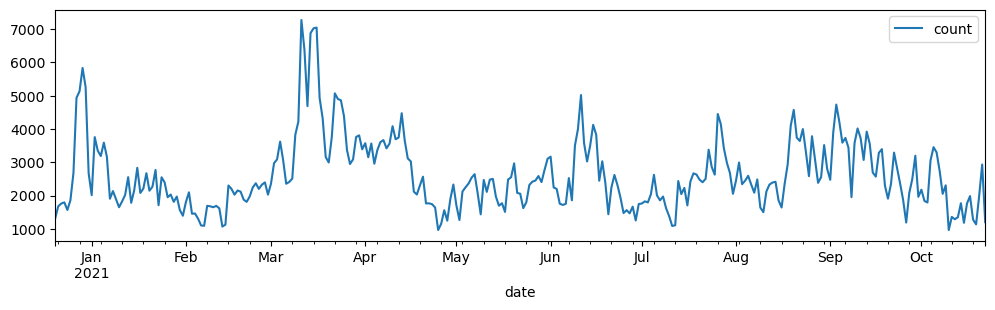

In [34]:
import matplotlib.pyplot as plt
fig = tweets_per_day_df.plot.line("date", "count", figsize=(12,3))

In [35]:
tweets_per_day_df.sort_values(by="count")

,date,count
294,2021-10-10,964
126,2021-04-25,964
55,2021-02-13,1067
203,2021-07-11,1085
49,2021-02-07,1090
...,...,...
82,2021-03-12,6377
84,2021-03-14,6873
85,2021-03-15,7019
86,2021-03-16,7042


In [36]:
dataset_df["user_id"].nunique()

72614

In [37]:
dataset_df

,id,created_at,user_id,user_screen_name,geo,place,lang,truncated,text,retweet_count,...,media,positive,neutral,negative,roots,quoted_roots,ng_ratings,ng_ratings_quoted,date,count
2,1340468299025551360,2020-12-20 01:25:21+00:00,497188910,Rosskitty77,NaN,NaN,und,NaN,NaN,4,...,NaN,NaN,NaN,NaN,['affaritaliani.it'],[],[64.5],[],20.12.2020,1
3,1340468728534884354,2020-12-20 01:27:04+00:00,924336025387913221,real_fabristol,NaN,NaN,it,NaN,"Covid, l’offensiva cinese: al via i vaccini ne...",0,...,NaN,0.000439,0.998082,0.001479,['lastampa.it'],[],[95.0],[],20.12.2020,1
5,1340473042129080320,2020-12-20 01:44:12+00:00,47148805,mcocucci,NaN,NaN,it,NaN,Non sono morte però sono state ricoverate in t...,0,...,NaN,0.002690,0.975340,0.021970,['nytimes.com'],[],[100.0],[],20.12.2020,1
6,1340474125656190978,2020-12-20 01:48:31+00:00,1022891525242593280,LisciandroC,NaN,NaN,it,NaN,Politici avvertiti: chi impone vaccini obbliga...,1,...,NaN,NaN,NaN,NaN,['imolaoggi.it'],[],[5.0],[],20.12.2020,1
7,1340477947627581440,2020-12-20 02:03:42+00:00,908206586,deegibons,NaN,NaN,it,NaN,Un virus più contagioso alla base della second...,0,...,NaN,NaN,NaN,NaN,"['repubblica.it', 'tweetedtimes.com']",[],[95.0],[],20.12.2020,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
198800,1451536158098399236,2021-10-22 13:09:22+00:00,1260895357548068865,negromanten1,NaN,NaN,it,0.0,"I vaccinati per forza non la prenderanno bene,...",0,...,NaN,NaN,NaN,NaN,['maurizioblondet.it'],[],[20.0],[],22.10.2021,1
198801,1451536212381011970,2021-10-22 13:09:35+00:00,1329549977463508993,MariaFi27832951,NaN,NaN,it,0.0,NaN,0,...,NaN,NaN,NaN,NaN,['stopcensura.online'],[],[39.5],[],22.10.2021,1
198802,1451536226876526601,2021-10-22 13:09:39+00:00,712365073,Alcesten,NaN,NaN,it,0.0,NaN,0,...,NaN,NaN,NaN,NaN,['lapekoranera.it'],[],[12.5],[],22.10.2021,1
198803,1451536327388942348,2021-10-22 13:10:03+00:00,1036611673,GiancarloChimie,NaN,NaN,it,0.0,NaN,0,...,NaN,NaN,NaN,NaN,['maurizioblondet.it'],[],[20.0],[],22.10.2021,1


In [ ]:
df[df["is_retweet"]==1][df["roots"] != '[]']

In [ ]:
df["created_at"] = pd.to_datetime(df["created_at"])

In [ ]:
df.sort_values(by="created_at")

In [ ]:
df[df["is_reply"] == 1]

In [ ]:
df[df["is_retweet"] == 1]

In [ ]:
df[df["is_quote"] == 1]